In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'spam-text-message-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2050%2F3494%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T130658Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6ce8cc0138761d2bbd965463ffca02cd16ca7192f3804700d380106a8ca444d38b3b06c83bb4a1b7e5a2ebad6989d7bd177698a76b1d5b19850fe464a3cdf7ed6482d2ba8c57c0d7bf7128e63d2e57f4842a4802b05114568b0872db6025a23653c31ae243a97ab05c9a29d5b2ac5c35428023aeff7c60d9b40ae65cd26dda77e5c30d313b62b9ef7fb71f56bb306ac2e269c62c42154643882d8e25beee000036e7e3253a04ec5af640d343fca2846d4eef6a3bd8d8acf7110f1d4633ecd42d6e9018c4d93a90855cacdf0a7b8d9e8b60461b09ed0f3fb77b4e8645bd76f3738e7c439cda57380643da0a2d1dfe0629347b6e62ca2049740b9e49dc33535923'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 213261 bytes downloaded
Downloaded and uncompressed: spam-text-message-classification
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv


In [3]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import re
import nltk
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn import metrics

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
from nltk import pos_tag
from nltk.corpus import wordnet

In [4]:
df1 = pd.read_csv("/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv")

In [ ]:
df1.shape

(5572, 2)

In [ ]:
df1.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df1.groupby(['Category']).describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [ ]:
df1.isnull().sum()

Category    0
Message     0
dtype: int64

In [23]:
#Since the database is big (5572) we are creating a subset database of 2500
df_ham = df1[df1["Category"]=="ham"][:2000]
df_spam = df1[df1["Category"]=="spam"][:700]
messeges = pd.concat([df_ham, df_spam])

In [24]:
messeges.shape

(2700, 2)

In [25]:
## cleaning the text

def cleantext(text):

    # removing the "\"

    text = re.sub("'\''","",text)

    # removing special symbols

    text = re.sub("[^a-zA-Z]"," ",text)

    # removing the whitespaces

    text = ' '.join(text.split())

    # convert text to lowercase

    text = text.lower()

    return text



messeges['Message'] = messeges['Message'].apply(lambda x:cleantext(x))
messeges['Message'].iloc[1]

'ok lar joking wif u oni'

In [26]:
!python -m nltk.downloader stopwords

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Install the stopwords corpus if it is not already installed
!python -m nltk.downloader stopwords

# Import the stopwords module
from nltk.corpus import stopwords

# Get a list of English stopwords
stopwords_list = stopwords.words('english')

# Print the list of stopwords
print(", ".join(stopwords_list))

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why

In [32]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:

def removestopwords(text):

    removedstopword = [word for word in text.split() if word not in stopwords_list]
    return ' '.join(removedstopword)

messeges['Message'] = messeges['Message'].apply(lambda x:removestopwords(x))
messeges['Message'].iloc[1]


'ok lar joking wif u oni'

In [35]:
print("hello")

hello


In [36]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Removing numbers
def remove_numbers(text):
    pattern = r'\d+'
    text = re.sub(pattern, '', text)
    return text

In [37]:
messeges['Message']=messeges['Message'].apply(remove_special_characters)
messeges['Message']=messeges['Message'].apply(remove_numbers)

In [38]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [39]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [40]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

In [41]:
#lemmatizing

lemma=WordNetLemmatizer()

def lematizing(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = lemma.lemmatize(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence


messeges['Message'] = messeges['Message'].apply(lambda x: lematizing(x))
messeges['Message'].iloc[1]

'ok lar joking wif u oni'

In [42]:
#stemming

# Approach

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stemming(sentence):

    stemmed_sentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemmed_sentence+=stem
        stemmed_sentence+=" "

    stemmed_sentence = stemmed_sentence.strip()
    return stemmed_sentence

messeges['Message'] = messeges['Message'].apply(lambda text:stemming(text))
messeges['Message'].iloc[1]

'ok lar joke wif u oni'

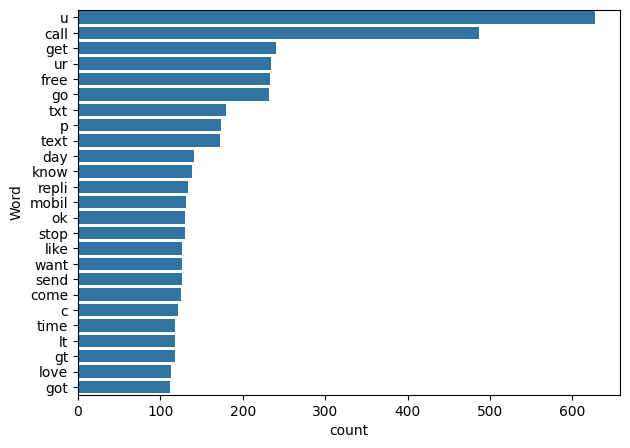

In [43]:
# visualising frewords

def showmostfrequentwords(text,no_of_words):

    allwords = ' '.join([char for char in text])
    allwords = allwords.split()
    fdist = nltk.FreqDist(allwords)

    wordsdf = pd.DataFrame({'word':list(fdist.keys()),'count':list(fdist.values())})

    df = wordsdf.nlargest(columns="count",n = no_of_words)

    plt.figure(figsize=(7,5))
    ax = sn.barplot(data=df,x = 'count',y = 'word')
    ax.set(ylabel = 'Word')
    plt.show()

    return wordsdf


# 25 most frequent words


freq_df = showmostfrequentwords(messeges['Message'],25)


In [50]:
y = np.array(messeges['Category'].map({'ham': 1, 'spam': 0}))

# **VECTORIZATION**

# **bag of word**

In [106]:
## count vectorizer
import time
def vectorize_text():
    count_vec = CountVectorizer(max_df=0.90,min_df=2,
                           max_features=10000 )

    bagofword_vec = count_vec.fit_transform(messeges['Message'])
start_time = time.perf_counter()
# Perform vectorization
vector = vectorize_text()

# End time measurement
end_time = time.perf_counter()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Computational time for vectorization: {elapsed_time:.4f} seconds")

bagofword_vec

Computational time for vectorization: 0.0817 seconds


<2700x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 16742 stored elements in Compressed Sparse Row format>

In [51]:
## count vectorizer

count_vec = CountVectorizer(max_df=0.90,min_df=2,
                           max_features=1000,stop_words='english')

bagofword_vec = count_vec.fit_transform(messeges['Message'])
bagofword_vec

<2700x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 16742 stored elements in Compressed Sparse Row format>

In [52]:
X_train, X_test, y_train, y_test = train_test_split(bagofword_vec,y,
                                                    test_size=0.2)
X_train.shape,X_test.shape

((2160, 1000), (540, 1000))

# **SVC**

In [70]:
from sklearn import metrics
from sklearn.svm import SVC


# Train the SVC model
svc = SVC()
svc.fit(X_train, y_train)

# Make predictions on the test set
svccpred = svc.predict(X_test)

# Calculate accuracy on the training and test sets
train_accuracy = svc.score(X_train, y_train)
test_accuracy = svc.score(X_test, y_test)

# Print the accuracy scores
print('Accuracy on training data: {:,.3f}'.format(train_accuracy))
print('Accuracy on test data: {:,.3f}'.format(test_accuracy))

Accuracy on training data: 0.986
Accuracy on test data: 0.969


In [71]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y_test, svccpred))
print(classification_report(y_test, svccpred))

[[118  14]
 [  3 405]]
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       132
           1       0.97      0.99      0.98       408

    accuracy                           0.97       540
   macro avg       0.97      0.94      0.96       540
weighted avg       0.97      0.97      0.97       540



# ***MULTINOMIALNB***

In [79]:
mb = MultinomialNB()
mb.fit(X_train,y_train)
mbpred = mb.predict(X_test)
print(metrics.accuracy_score(y_test,mbpred))
print('Accuracy on training data: {:,.3f}'.format(mb.score (X_train, y_train)))

print('Accuracy on test data: {:,.3f}'.format(mb.score (X_test, y_test)))

0.9666666666666667
Accuracy on training data: 0.976
Accuracy on test data: 0.967


In [78]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y_test, mbpred))
print(classification_report(y_test, mbpred))

[[126   6]
 [ 12 396]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       132
           1       0.99      0.97      0.98       408

    accuracy                           0.97       540
   macro avg       0.95      0.96      0.96       540
weighted avg       0.97      0.97      0.97       540



# **LOGISTIC REGRESSION**

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Define the LogisticRegression model
log_reg = LogisticRegression()

# Fit the model on the training data
log_reg.fit(X_train, y_train)

# Make predictions on the test data
model4_pred = log_reg.predict(X_test)

# Evaluate the accuracy of the model
print(metrics.accuracy_score(y_test, model4_pred))

print('Accuracy on training data: {:,.3f}'.format(log_reg.score (X_train, y_train)))

print('Accuracy on test data: {:,.3f}'.format(log_reg.score (X_test, y_test)))

0.9722222222222222
Accuracy on training data: 0.985
Accuracy on test data: 0.972


In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y_test, model4_pred))
print(classification_report(y_test, model4_pred))

[[119  13]
 [  2 406]]
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       132
           1       0.97      1.00      0.98       408

    accuracy                           0.97       540
   macro avg       0.98      0.95      0.96       540
weighted avg       0.97      0.97      0.97       540



# **NAIVE BAYERS**

In [84]:
#Naive Bayes Classifier

from sklearn.naive_bayes import GaussianNB

gnb= GaussianNB()

# Convert X_train to a dense NumPy array
X_train_dense = X_train.toarray()

# Convert X_test to a dense NumPy array
X_test_dense = X_test.toarray()

gnb.fit(X_train_dense,y_train)

gnbpred = gnb.predict(X_test_dense)

print(metrics.accuracy_score(y_test, gnbpred))

print('Accuracy on training data: {:,.3f}'.format(gnb.score (X_train_dense, y_train)))

print('Accuracy on test data: {:,.3f}'.format(gnb.score (X_test_dense, y_test)))

0.8
Accuracy on training data: 0.812
Accuracy on test data: 0.800


In [89]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y_test, gnbpred))
print(classification_report(y_test, gnbpred))

[[130   2]
 [106 302]]
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       132
           1       0.99      0.74      0.85       408

    accuracy                           0.80       540
   macro avg       0.77      0.86      0.78       540
weighted avg       0.89      0.80      0.81       540



# ** TF-IDF (Term Frequency-Inverse Document Frequency)**

In [107]:
import time
def vectorize_text():
    tfidf_vectorizer = TfidfVectorizer(max_df=0.90,min_df=2,
                           max_features=10000)
    tfidf_vec = tfidf_vectorizer.fit_transform(messeges['Message'])

start_time = time.perf_counter()
# Perform vectorization
vector = vectorize_text()

# End time measurement
end_time = time.perf_counter()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Computational time for vectorization: {elapsed_time:.4f} seconds")

Computational time for vectorization: 0.0846 seconds


In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

tfidf_matrix = tfidf_vec.fit_transform(messeges['Message'])
tfidf_matrix


<2700x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 16742 stored elements in Compressed Sparse Row format>

In [93]:
X2_train, X2_test, y2_train, y2_test = train_test_split(tfidf_matrix,y,
                                                    test_size=0.2)
X2_train.shape,X2_test.shape

((2160, 1000), (540, 1000))

In [94]:
from sklearn import metrics
from sklearn.svm import SVC


# Train the SVC model
svc = SVC()
svc.fit(X2_train, y2_train)

# Make predictions on the test set
svccpred = svc.predict(X2_test)

# Calculate accuracy on the training and test sets
train_accuracy = svc.score(X2_train, y2_train)
test_accuracy = svc.score(X2_test, y2_test)

# Print the accuracy scores
print('Accuracy on training data: {:,.3f}'.format(train_accuracy))
print('Accuracy on test data: {:,.3f}'.format(test_accuracy))

Accuracy on training data: 0.995
Accuracy on test data: 0.967


In [95]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y2_test, svccpred))
print(classification_report(y2_test, svccpred))

[[123  16]
 [  2 399]]
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       139
           1       0.96      1.00      0.98       401

    accuracy                           0.97       540
   macro avg       0.97      0.94      0.95       540
weighted avg       0.97      0.97      0.97       540



# **MULTINOMIALNB**

In [97]:
mb = MultinomialNB()
mb.fit(X2_train,y2_train)
mbpred = mb.predict(X2_test)
print(metrics.accuracy_score(y2_test,mbpred))
print('Accuracy on training data: {:,.3f}'.format(mb.score (X2_train, y2_train)))

print('Accuracy on test data: {:,.3f}'.format(mb.score (X2_test, y2_test)))

0.9648148148148148
Accuracy on training data: 0.979
Accuracy on test data: 0.965


In [98]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y2_test, mbpred))
print(classification_report(y2_test, mbpred))

[[125  14]
 [  5 396]]
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       139
           1       0.97      0.99      0.98       401

    accuracy                           0.96       540
   macro avg       0.96      0.94      0.95       540
weighted avg       0.96      0.96      0.96       540



# **LOGISTIC REGRESSION**

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Define the LogisticRegression model
log_reg = LogisticRegression()

# Fit the model on the training data
log_reg.fit(X2_train, y2_train)

# Make predictions on the test data
model4_pred = log_reg.predict(X2_test)

# Evaluate the accuracy of the model
print(metrics.accuracy_score(y2_test, model4_pred))

print('Accuracy on training data: {:,.3f}'.format(log_reg.score (X2_train, y2_train)))

print('Accuracy on test data: {:,.3f}'.format(log_reg.score (X2_test, y2_test)))

0.9611111111111111
Accuracy on training data: 0.971
Accuracy on test data: 0.961


In [100]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y2_test, model4_pred))
print(classification_report(y2_test, model4_pred))

[[119  20]
 [  1 400]]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       139
           1       0.95      1.00      0.97       401

    accuracy                           0.96       540
   macro avg       0.97      0.93      0.95       540
weighted avg       0.96      0.96      0.96       540



# **NAIVE BAYERS**

In [101]:
#Naive Bayes Classifier

from sklearn.naive_bayes import GaussianNB

gnb= GaussianNB()

# Convert X_train to a dense NumPy array
X2_train_dense = X2_train.toarray()

# Convert X_test to a dense NumPy array
X2_test_dense = X2_test.toarray()

gnb.fit(X2_train_dense,y2_train)

gnbpred = gnb.predict(X2_test_dense)

print(metrics.accuracy_score(y2_test, gnbpred))

print('Accuracy on training data: {:,.3f}'.format(gnb.score (X2_train_dense, y2_train)))

print('Accuracy on test data: {:,.3f}'.format(gnb.score (X2_test_dense, y2_test)))

0.8203703703703704
Accuracy on training data: 0.862
Accuracy on test data: 0.820


In [102]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Print the confusion matrix
print(confusion_matrix(y2_test, gnbpred))
print(classification_report(y2_test, gnbpred))

[[128  11]
 [ 86 315]]
              precision    recall  f1-score   support

           0       0.60      0.92      0.73       139
           1       0.97      0.79      0.87       401

    accuracy                           0.82       540
   macro avg       0.78      0.85      0.80       540
weighted avg       0.87      0.82      0.83       540



In [104]:
## count vectorizer
import time
def vectorize_text():
    count_vec = CountVectorizer(max_df=0.90,min_df=2,
                           max_features=10000 )

    bagofword_vec = count_vec.fit_transform(messeges['Message'])
start_time = time.perf_counter()
# Perform vectorization
vector = vectorize_text()

# End time measurement
end_time = time.perf_counter()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Computational time for vectorization: {elapsed_time:.4f} seconds")

bagofword_vec

Computational time for vectorization: 0.0769 seconds


<2700x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 16742 stored elements in Compressed Sparse Row format>